In [1]:
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage
from aicsimageio import AICSImage
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.filters import threshold_otsu, threshold_local, gaussian
from skimage.morphology import (
    remove_small_objects, remove_small_holes, binary_dilation, binary_erosion, disk
)
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import regionprops_table
from scipy import ndimage as ndi
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

ModuleNotFoundError: No module named 'aicsimageio'

In [ ]:
# file_name = f"/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Microscopy Data Huntingtin aggregates/Raw data #1/20240131_CKR_E10B_mHtt-HAQ25Doxy96H_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_1.lif"
file_name = f"/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Microscopy Data Huntingtin aggregates/Raw data #1/20240131_CKR_E10B_mHtt-HAQ25Doxy96H_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_1.lif"

# Using AICSImage to load the file
img = AICSImage(file_name)
print(img.dims.order)  # I print the dimensions of the data (mainy to check on amount of the z-slices and channels)
print(img.dask_data)  #  Allows me to work with the image data without loading the entire dataset into memory at once.

# For TIFF files, I use the AICSImage's properties instead of LifFile
print(f"Shape: {img.shape}")
print(f"Dimensions: {img.dims}")
print(f"Number of channels: {img.dims.C}")
if hasattr(img.dims, 'Z'):
    print(f"Number of Z slices: {img.dims.Z}")
else:
    print("This image doesn't have a Z dimension")

# Accessing image data
image_data = img.get_image_data("YX", C=0)  # Get first channel
print(f"Shape of the first channel: {image_data.shape}")


TCZYX
dask.array<transpose, shape=(1, 4, 9, 2168, 2168), dtype=uint16, chunksize=(1, 1, 9, 2168, 2168), chunktype=numpy.ndarray>
Shape: (1, 4, 9, 2168, 2168)
Dimensions: <Dimensions [T: 1, C: 4, Z: 9, Y: 2168, X: 2168]>
Number of channels: 4
Number of Z slices: 9
Shape of the first channel: (2168, 2168)


when combining the slices, I use a maximum intensity projection (MIP). It works like this:
	•	I go through each pixel column in the Z-stack (i.e., the same (X, Y) position across all Z-layers).
	•	For each (X, Y) pixel location, I select the maximum intensity value from all Z-slices.
	•	The result is a single 2D image where each pixel shows the brightest value observed in that column of Z-slices.

This is particularly useful because i'm trying to highlight aggregates that might only appear in some of the Z-layers, because it ensures nothing bright is “hidden” in the stack.


Empirical example:
	•	An aggregate might appear clearly in slice Z=4, but not in others.
	•	A maximum projection would “pull out” the signal from Z=4 into the final 2D image.
	•	That way, the detection algorithm doesn’t miss it.

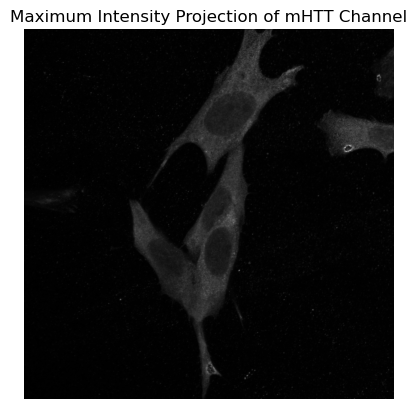

In [ ]:
# Extract Z-stack data for the mHTT channel (e.g., channel 0)
image_data_all_z = img.get_image_data("ZYX", C=0)  # shape: (Z, Y, X)

# Compute the maximum intensity projection along the Z-axis
max_proj = np.max(image_data_all_z, axis=0)

# Display the maximum intensity projection
plt.imshow(max_proj, cmap='gray')
plt.title("Maximum Intensity Projection of mHTT Channel")
plt.axis('off')
plt.show()

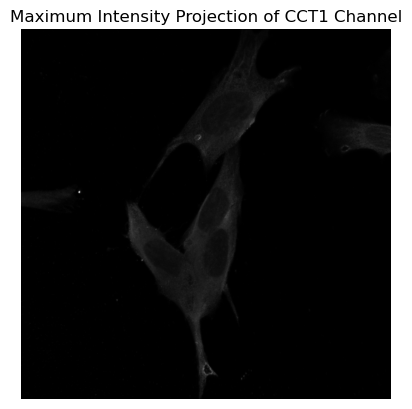

In [ ]:
# Get all Z-slices from CCT1 channel (Channel 1)
cct1_data_all_z = img.get_image_data("ZYX", C=1)  # shape: (Z, Y, X)

# Compute the max intensity projection
cct1_max_proj = np.max(cct1_data_all_z, axis=0)

# Display
plt.imshow(cct1_max_proj, cmap='gray')
plt.title("Maximum Intensity Projection of CCT1 Channel")
plt.axis('off')
plt.show()

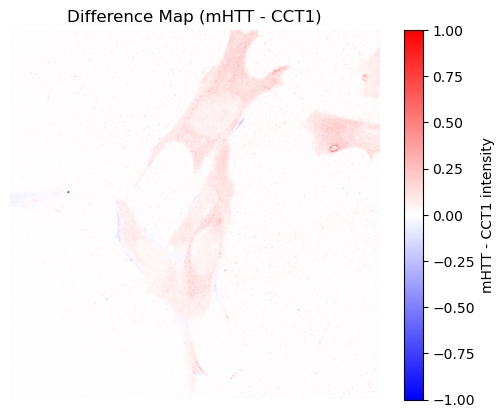

In [ ]:
# Get Z-stack projections
mhtt_proj = np.max(img.get_image_data("ZYX", C=0), axis=0)
cct1_proj = np.max(img.get_image_data("ZYX", C=1), axis=0)

# Normalize both to 0–1 for fair subtraction
mhtt_norm = (mhtt_proj - np.min(mhtt_proj)) / np.ptp(mhtt_proj)
cct1_norm = (cct1_proj - np.min(cct1_proj)) / np.ptp(cct1_proj)

# Subtract: positive = mHTT-dominant, negative = CCT1-dominant
diff = mhtt_norm - cct1_norm

# Show the difference map
plt.imshow(diff, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(label='mHTT - CCT1 intensity')
plt.title("Difference Map (mHTT - CCT1)")
plt.axis('off')
plt.show()

In [ ]:
# Automatic thresholding
thresh_mhtt = threshold_otsu(mhtt_proj)
thresh_cct1 = threshold_otsu(cct1_proj)

# Binary masks
mask_mhtt = mhtt_proj > thresh_mhtt
mask_cct1 = cct1_proj > thresh_cct1

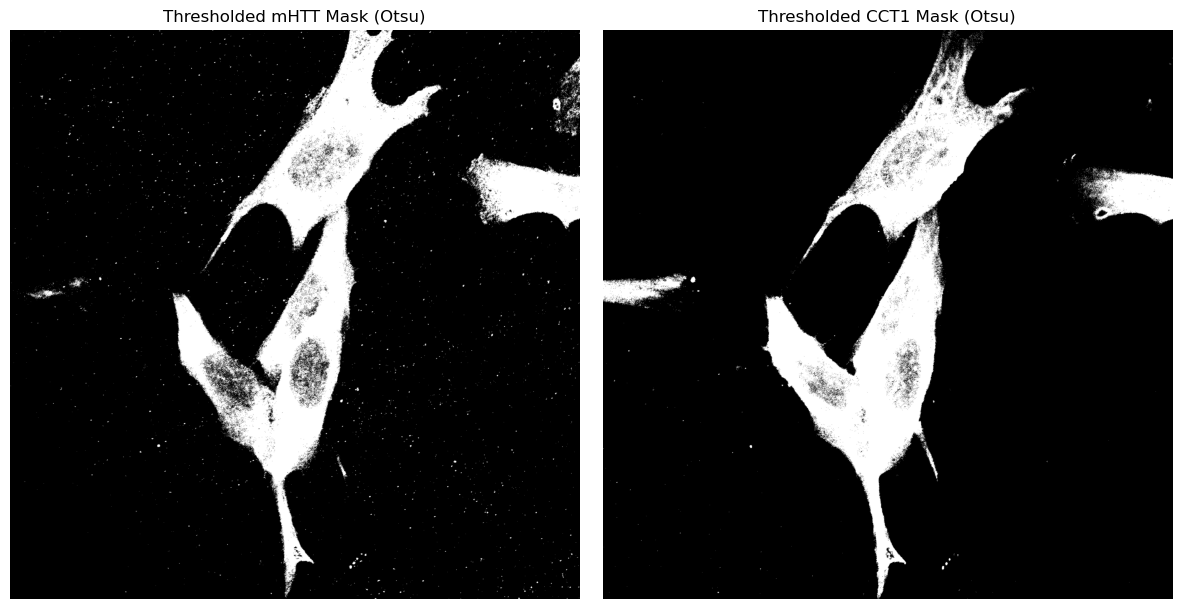

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# mHTT mask
axs[0].imshow(mask_mhtt, cmap='gray')
axs[0].set_title("Thresholded mHTT Mask (Otsu)")
axs[0].axis('off')

# CCT1 mask
axs[1].imshow(mask_cct1, cmap='gray')
axs[1].set_title("Thresholded CCT1 Mask (Otsu)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

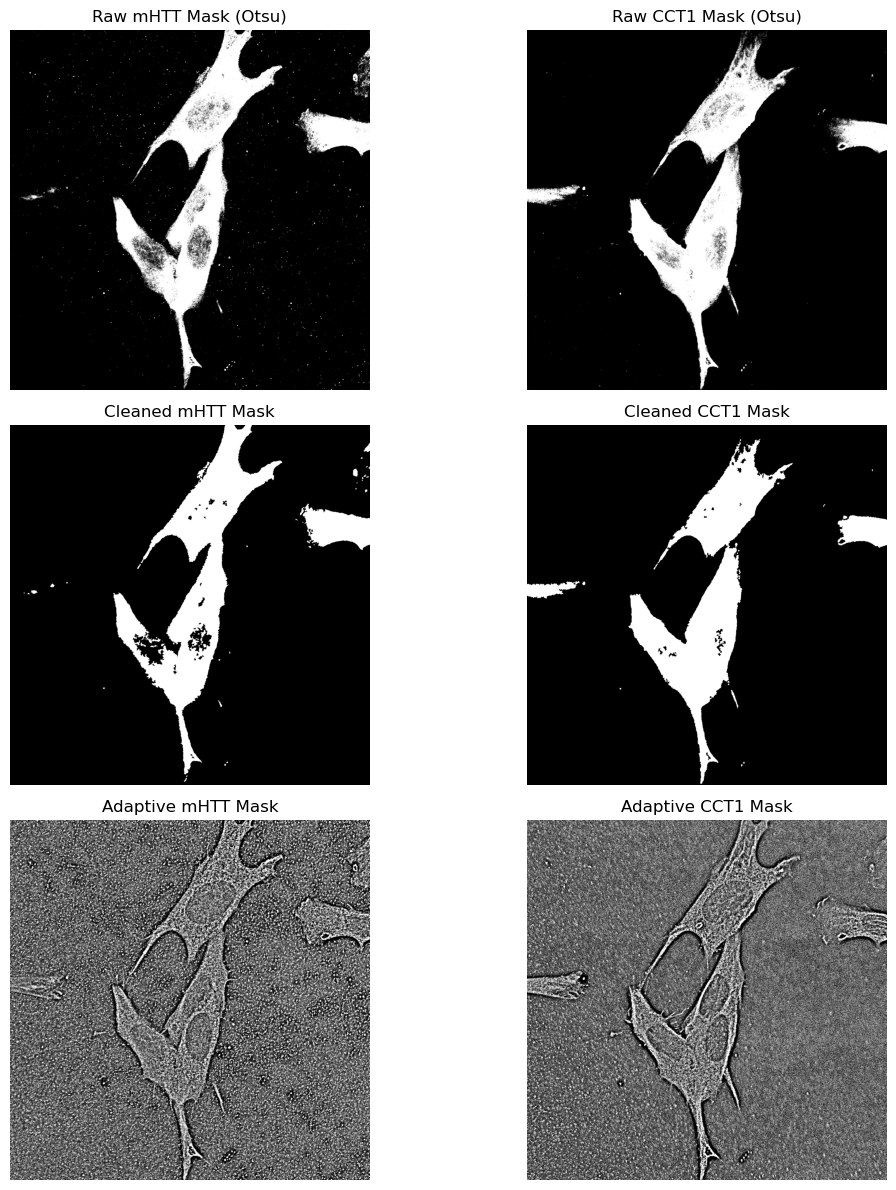

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_local
from skimage.morphology import (
    remove_small_objects,
    remove_small_holes,
    binary_opening,
    disk
)

# --- Threshold with Otsu ---
thresh_mhtt = threshold_otsu(mhtt_proj)
thresh_cct1 = threshold_otsu(cct1_proj)

mask_mhtt = mhtt_proj > thresh_mhtt
mask_cct1 = cct1_proj > thresh_cct1

# --- Morphological cleanup (Otsu masks) ---
mask_mhtt_clean = remove_small_objects(mask_mhtt, min_size=64)
mask_mhtt_clean = remove_small_holes(mask_mhtt_clean, area_threshold=64)
mask_mhtt_clean = binary_opening(mask_mhtt_clean, footprint=disk(2))

mask_cct1_clean = remove_small_objects(mask_cct1, min_size=64)
mask_cct1_clean = remove_small_holes(mask_cct1_clean, area_threshold=64)
mask_cct1_clean = binary_opening(mask_cct1_clean, footprint=disk(2))

# --- (Optional) Adaptive Thresholding ---
adaptive_thresh_mhtt = threshold_local(mhtt_proj, block_size=51, offset=10)
adaptive_mask_mhtt = mhtt_proj > adaptive_thresh_mhtt

adaptive_thresh_cct1 = threshold_local(cct1_proj, block_size=51, offset=10)
adaptive_mask_cct1 = cct1_proj > adaptive_thresh_cct1

# --- Visualization ---
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].imshow(mask_mhtt, cmap='gray')
axs[0, 0].set_title("Raw mHTT Mask (Otsu)")
axs[0, 1].imshow(mask_cct1, cmap='gray')
axs[0, 1].set_title("Raw CCT1 Mask (Otsu)")

axs[1, 0].imshow(mask_mhtt_clean, cmap='gray')
axs[1, 0].set_title("Cleaned mHTT Mask")
axs[1, 1].imshow(mask_cct1_clean, cmap='gray')
axs[1, 1].set_title("Cleaned CCT1 Mask")

axs[2, 0].imshow(adaptive_mask_mhtt, cmap='gray')
axs[2, 0].set_title("Adaptive mHTT Mask")
axs[2, 1].imshow(adaptive_mask_cct1, cmap='gray')
axs[2, 1].set_title("Adaptive CCT1 Mask")

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

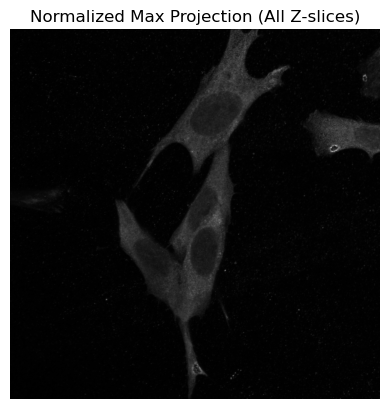

In [ ]:
# Normalize the projection to [0, 1] for better contrast
mhtt_proj = (mhtt_proj - np.min(mhtt_proj)) / np.ptp(mhtt_proj)

# Optional: check it
plt.imshow(mhtt_proj, cmap='gray')
plt.title("Normalized Max Projection (All Z-slices)")
plt.axis('off')
plt.show()

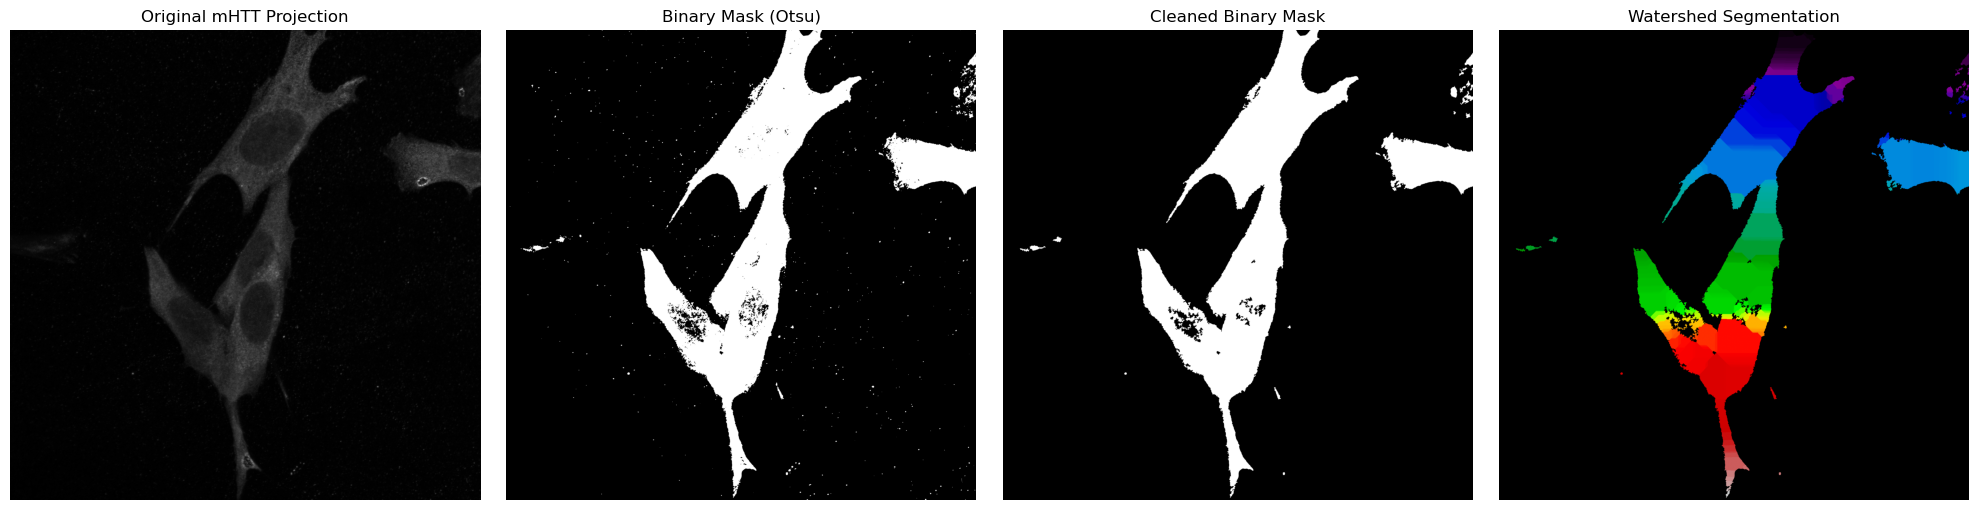

In [ ]:
# Step 1: Apply gaussian blur to reduce noise
mhtt_blurred = gaussian(mhtt_proj, sigma=1)

# Step 2: Otsu thresholding (skip adaptive)
binary_mask = mhtt_blurred > threshold_otsu(mhtt_blurred)

# Step 3: Aggressive morphological cleaning
binary_clean = remove_small_objects(binary_mask, min_size=100)
binary_clean = remove_small_holes(binary_clean, area_threshold=100)

# Step 4: Watershed segmentation
distance = ndi.distance_transform_edt(binary_clean)
coordinates = peak_local_max(distance, labels=binary_clean)
local_maxi = np.zeros_like(distance, dtype=bool)
local_maxi[tuple(coordinates.T)] = True
markers = ndi.label(local_maxi)[0]
labels_ws = watershed(-distance, markers, mask=binary_clean)

# Visualize all steps
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(mhtt_proj, cmap='gray')
axs[0].set_title("Original mHTT Projection")
axs[0].axis('off')

axs[1].imshow(binary_mask, cmap='gray')
axs[1].set_title("Binary Mask (Otsu)")
axs[1].axis('off')

axs[2].imshow(binary_clean, cmap='gray')
axs[2].set_title("Cleaned Binary Mask")
axs[2].axis('off')

axs[3].imshow(labels_ws, cmap='nipy_spectral')
axs[3].set_title("Watershed Segmentation")
axs[3].axis('off')

plt.tight_layout()
plt.show()
plt.show()


In [ ]:
# Try skipping adaptive thresholding
binary_mask = mhtt_blurred > threshold_otsu(mhtt_blurred)

# Less aggressive cleaning
binary_clean = remove_small_objects(binary_mask, min_size=20)
binary_clean = remove_small_holes(binary_clean, area_threshold=20)

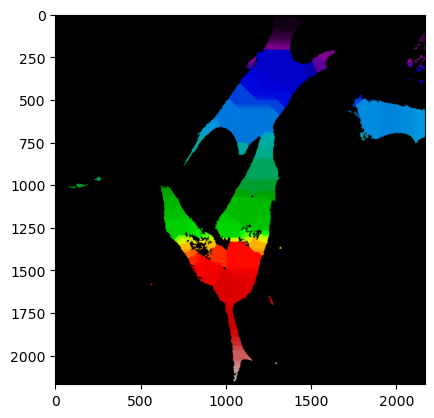

In [ ]:
plt.imshow(labels_ws, cmap='nipy_spectral')



⸻

🔬 Panel 1: Original mHTT Projection
	•	This is the maximum intensity projection across all Z-slices of the mHTT channel (C=0).
	•	It shows all detectable mutant huntingtin signal in one 2D image.
	•	You can see clear cell outlines and darker centers — likely nuclei (where mHTT signal is reduced).

🧠 This is your reference — you want all subsequent masks to map meaningfully to this.

⸻

⚪ Panel 2: Binary Mask (Otsu)
	•	This is a global threshold using Otsu’s method applied after Gaussian blur.
	•	It includes everything above a single intensity cutoff, so:
	•	It captures bright aggregates.
	•	But also includes cytoplasmic background, which may not be of interest.

🧠 This is a high-recall mask — useful as a starting point but noisy.

⸻

🧼 Panel 3: Cleaned Binary Mask
	•	This applies:
	•	remove_small_objects(min_size=100)
	•	remove_small_holes(area_threshold=100)
	•	The goal here is to remove noise and cytoplasmic haze, retaining only larger and more consistent aggregates.
	•	You can see it’s much more selective — only a handful of denser areas remain.

🧠 These regions are now candidate aggregates — useful for watershed.

⸻

🌈 Panel 4: Watershed Segmentation
	•	This is where the magic happens:
	•	The cleaned binary mask is converted to a distance map.
	•	Local maxima (peaks) are labeled.
	•	Watershed floods the space between peaks to segment touching objects.
	•	Each color = one aggregate region.
	•	Black areas: not part of any segment (too dim, or filtered out).

🧠 This gives you isolated, labeled mHTT aggregate candidates — ready for:
	•	Size and intensity measurement
	•	Spatial overlap with CCT1
	•	Aggregate size stratification

⸻

✅ What This Tells You (Biologically)
	•	You’ve now isolated discrete mHTT-positive structures that are:
	•	Larger than noise specks
	•	High enough intensity to survive thresholding
	•	These can now be:
	•	Quantified (size, shape, intensity)
	•	Analyzed for CCT1 colocalization
	•	Classified as nuclear vs cytoplasmic once nuclei masks are available

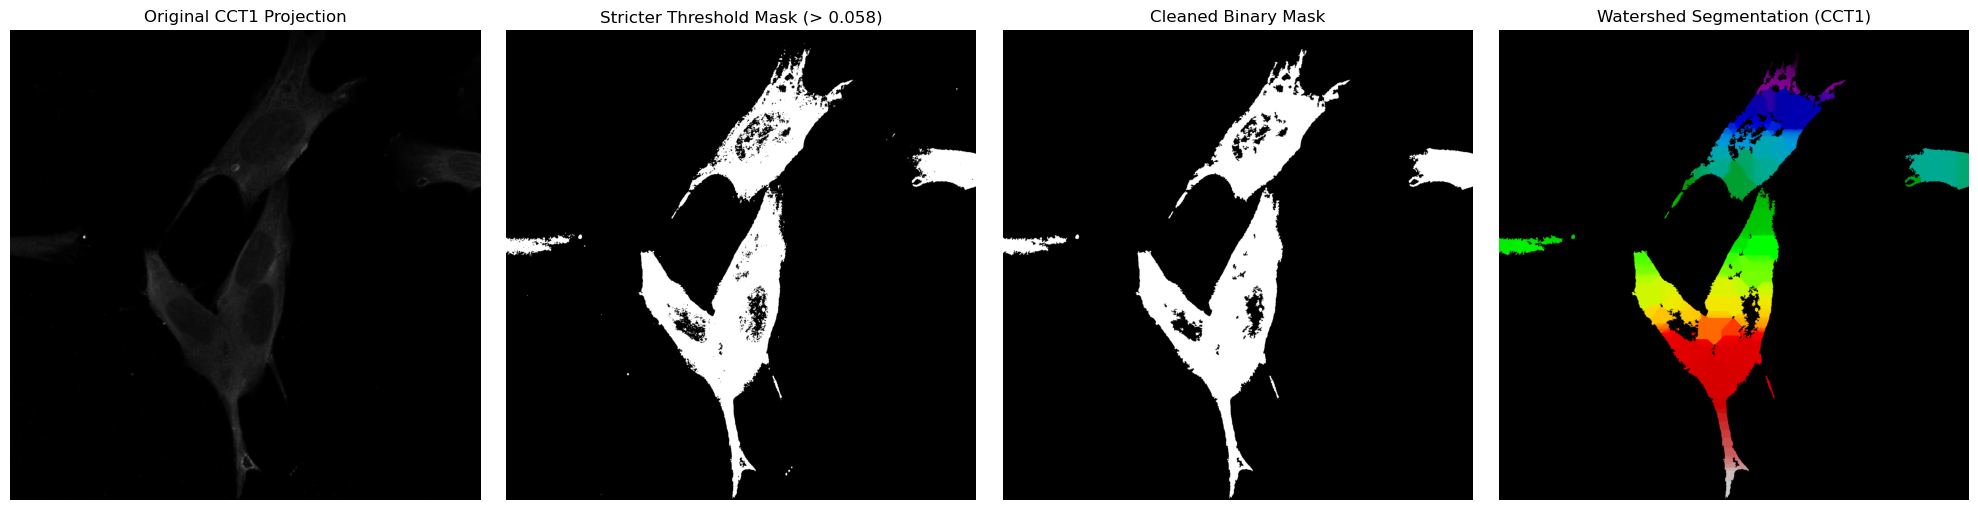

In [ ]:
# --- Step 1: Load and Normalize CCT1 Projection (Channel 1) ---
cct1_proj = np.max(img.get_image_data("ZYX", C=1), axis=0)
cct1_proj = (cct1_proj - np.min(cct1_proj)) / np.ptp(cct1_proj)  # Normalize to [0, 1]

# --- Step 2: Preprocessing (Gaussian blur) ---
cct1_blurred = gaussian(cct1_proj, sigma=1)

# --- Step 3: Stricter Otsu-Based Thresholding ---
otsu_val = threshold_otsu(cct1_blurred)
strict_thresh = otsu_val * 1.3  # adjust this factor as needed
cct1_mask = cct1_blurred > strict_thresh

# --- Step 4: Morphological Cleaning ---
cct1_clean = remove_small_objects(cct1_mask, min_size=100)
cct1_clean = remove_small_holes(cct1_clean, area_threshold=100)

# --- Step 5: Watershed Segmentation ---
cct1_distance = ndi.distance_transform_edt(cct1_clean)
cct1_coordinates = peak_local_max(cct1_distance, labels=cct1_clean)
cct1_local_maxi = np.zeros_like(cct1_distance, dtype=bool)
cct1_local_maxi[tuple(cct1_coordinates.T)] = True
cct1_markers = ndi.label(cct1_local_maxi)[0]
cct1_labels_ws = watershed(-cct1_distance, cct1_markers, mask=cct1_clean)

# --- Step 6: Visualize CCT1 Processing ---
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(cct1_proj, cmap='gray')
axs[0].set_title("Original CCT1 Projection")
axs[0].axis('off')

axs[1].imshow(cct1_mask, cmap='gray')
axs[1].set_title(f"Stricter Threshold Mask (> {strict_thresh:.3f})")
axs[1].axis('off')

axs[2].imshow(cct1_clean, cmap='gray')
axs[2].set_title("Cleaned Binary Mask")
axs[2].axis('off')

axs[3].imshow(cct1_labels_ws, cmap='nipy_spectral')
axs[3].set_title("Watershed Segmentation (CCT1)")
axs[3].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
colocal_props = regionprops_table(
    labels_ws,
    intensity_image=cct1_proj,  # normalized max projection of CCT1
    properties=[
        'label', 'area',
        'mean_intensity', 'max_intensity', 'min_intensity'
    ]
)

df_colocal = pd.DataFrame(colocal_props)
df_colocal.rename(columns={
    'mean_intensity': 'CCT1_mean_intensity',
    'max_intensity': 'CCT1_max_intensity',
    'min_intensity': 'CCT1_min_intensity'
}, inplace=True)

df_colocal.head()

,label,area,CCT1_mean_intensity,CCT1_max_intensity,CCT1_min_intensity
0,1,171.0,0.028634,0.061845,0.005768
1,2,169.0,0.026499,0.061906,0.005188
2,3,98.0,0.027855,0.061845,0.006668
3,4,58.0,0.027573,0.055924,0.009827
4,5,487.0,0.026776,0.062593,0.004654


In [ ]:
df_mhtt_props = pd.DataFrame(regionprops_table(
    labels_ws,
    intensity_image=mhtt_proj,
    properties=[
        'label', 'area', 'eccentricity', 'solidity',
        'mean_intensity', 'max_intensity', 'centroid'
    ]
)).rename(columns={
    'mean_intensity': 'mHTT_mean_intensity',
    'max_intensity': 'mHTT_max_intensity'
})

In [ ]:
df_cct1_props = pd.DataFrame(regionprops_table(
    labels_ws,
    intensity_image=cct1_proj,
    properties=[
        'label',
        'mean_intensity', 'max_intensity', 'min_intensity'
    ]
)).rename(columns={
    'mean_intensity': 'CCT1_mean_intensity',
    'max_intensity': 'CCT1_max_intensity',
    'min_intensity': 'CCT1_min_intensity'
})

In [ ]:
df_combined = df_mhtt_props.merge(df_cct1_props, on='label')
df_combined.head()

,label,area,eccentricity,solidity,mHTT_mean_intensity,mHTT_max_intensity,centroid-0,centroid-1,CCT1_mean_intensity,CCT1_max_intensity,CCT1_min_intensity
0,1,171.0,0.998768,1.000000,0.141523,0.246185,1.000000,1323.000000,0.028634,0.061845,0.005768
1,2,169.0,0.992274,0.949438,0.142390,0.290867,1.757396,1438.775148,0.026499,0.061906,0.005188
2,3,98.0,0.995650,0.859649,0.131862,0.284588,5.581633,1438.622449,0.027855,0.061845,0.006668
3,4,58.0,0.997485,0.816901,0.133534,0.253865,8.172414,1439.155172,0.027573,0.055924,0.009827
4,5,487.0,0.935235,0.804959,0.157280,0.337185,13.349076,1431.008214,0.026776,0.062593,0.004654


on this test picture we now have a solid dataset with 1380 mHTT aggregates, each annotated with:
	•	Morphological features (area, eccentricity, solidity)
	•	mHTT intensity (mean and max)
	•	CCT1 intensity (mean, max, min within each mHTT region)

⸻

🔍 Key Biological Insights

1. Aggregate Size (Area)
	•	Range: 1 to 50,202 pixels — wide variance, with some very large outliers
	•	75% of aggregates are smaller than ~241 pixels → the majority are small/medium
	•	✅ This is ideal for size-stratified colocalization analysis

⸻

2. Shape Metrics
	•	Eccentricity: Mean ≈ 0.81
→ Most aggregates are elongated rather than round (1 = line, 0 = circle)
	•	Solidity: Mean ≈ 0.89
→ Most are solid, not perforated or fragmented

⸻

3. mHTT Intensity
	•	Mean ≈ 0.13 | Max up to 1.0
→ Aggregates are reasonably bright
→ Good dynamic range across the dataset

⸻

4. CCT1 Intensity at Aggregates
	•	Mean ≈ 0.064 | Max ≈ 0.46
→ CCT1 signal is much weaker than mHTT, but present
→ Variation in CCT1_max suggests selective colocalization at some sites

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Compute Pearson correlation
pearson_corr, pearson_p = pearsonr(df["mHTT_mean_intensity"], df["CCT1_mean_intensity"])

# Plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df,
    x="mHTT_mean_intensity",
    y="CCT1_mean_intensity",
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

# Annotate correlation value
plt.text(
    0.05, 0.28,
    f"Pearson r = {pearson_corr:.2f}\n(p = {pearson_p:.1e})",
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8)
)

# Plot settings
plt.title("CCT1 vs. mHTT Mean Intensity per Aggregate\n(with Regression Line)")
plt.xlabel("mHTT Mean Intensity")
plt.ylabel("CCT1 Mean Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

🔍 Key Observations

✅ 1. Positive Correlation
	•	The Pearson correlation coefficient r = 0.51, with an extremely small p-value (1.3e-91), confirms a moderate and highly significant linear relationship.
	•	This means that brighter mHTT aggregates tend to have more CCT1 localized at them.

🎯 2. Trend Reinforced by Regression Line
	•	The fitted regression line clearly shows a positive slope, supporting the idea that CCT1 recruitment scales with mHTT intensity.
	•	This visual cue strengthens the statistical correlation and makes the pattern easy to interpret.

⚠️ 3. Heterogeneity & Outliers
	•	Despite the trend, there’s substantial spread around the line:
	•	Some high-intensity mHTT aggregates have low CCT1 — suggesting non-recruitment or saturation.
	•	Conversely, some lower mHTT aggregates show unexpectedly high CCT1, possibly reflecting early recruitment or independent CCT1 accumulation.

“These data suggest that CCT1 recruitment is positively associated with mHTT aggregation, but not uniformly. This heterogeneity supports the hypothesis that CCT1 selectively engages with certain aggregate populations, potentially reflecting functional or structural differences in mHTT species.”

In [ ]:
import tifffile
import nibabel as nib
import numpy as np

# Load TIFF max projection
image = tifffile.imread("/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Microscopy Data Huntingtin aggregates/Raw data #1/20240131_CKR_E10B_mHtt-HAQ25Doxy96H_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_1.lif")

# Normalize
image = (image - image.min()) / (image.ptp())

# Save as NIfTI
nib.save(nib.Nifti1Image(image.astype(np.float32), affine=np.eye(4)), "case_001_0000.nii.gz")

In [ ]:
# binary mask (e.g., from thresholding or watershed)
nib.save(nib.Nifti1Image(mask.astype(np.uint8), affine=np.eye(4)), "case_001.nii.gz")

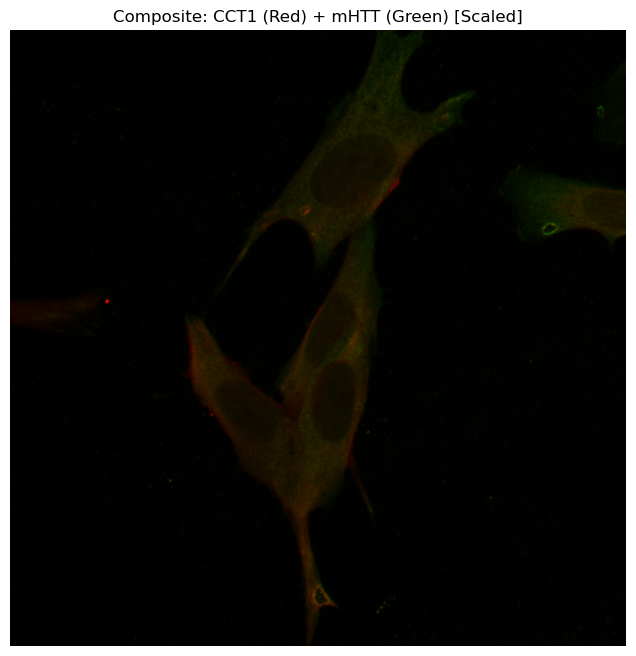

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Load and normalize mHTT and CCT1 projections ---
mhtt_proj = np.max(img.get_image_data("ZYX", C=0), axis=0)
cct1_proj = np.max(img.get_image_data("ZYX", C=1), axis=0)

# Normalize each to [0, 1]
mhtt_norm = (mhtt_proj - mhtt_proj.min()) / mhtt_proj.ptp()
cct1_norm = (cct1_proj - cct1_proj.min()) / cct1_proj.ptp()

# --- Step 2: Adjust brightness scaling ---
green_scale = 0.5  # adjust this to reduce mHTT visibility (0.5 = 50%)
red_scale = 1.2    # boost CCT1 visibility

# Apply scaling
mhtt_scaled = np.clip(mhtt_norm * green_scale, 0, 1)
cct1_scaled = np.clip(cct1_norm * red_scale, 0, 1)

# --- Step 3: Build RGB composite ---
composite_rgb = np.stack([cct1_scaled, mhtt_scaled, np.zeros_like(mhtt_scaled)], axis=-1)

# --- Step 4: Show the image ---
plt.figure(figsize=(8, 8))
plt.imshow(composite_rgb)
plt.title("Composite: CCT1 (Red) + mHTT (Green) [Scaled]")
plt.axis('off')
plt.show()

vization based on projection of the two channels on toop of each other: 

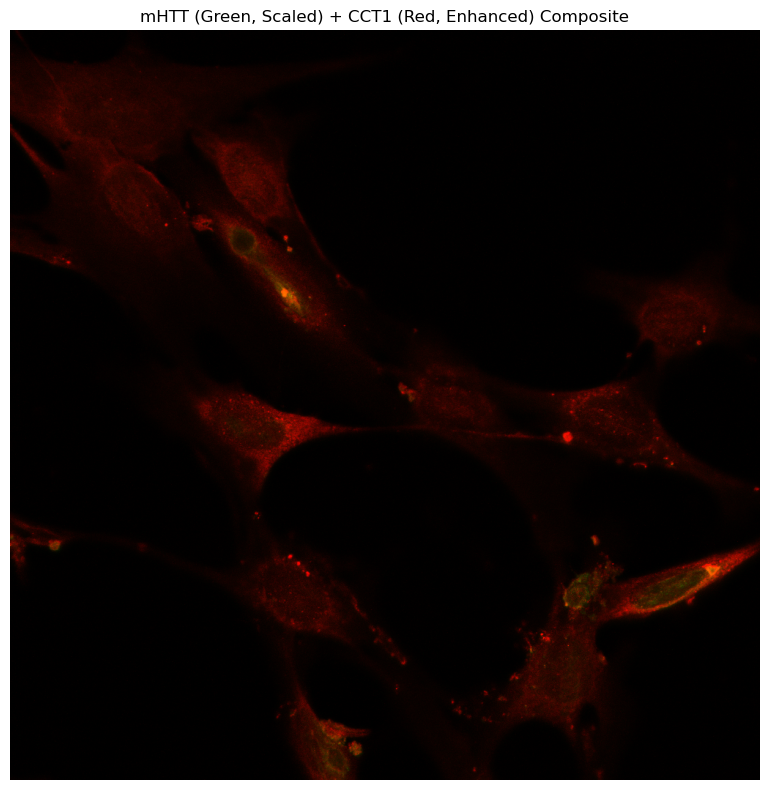

In [ ]:

# --- Step 1: Load the .lif file ---
file_path = "/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Images Carolina/E35/20240312_CKR_Exp35_STHdhQ97HA_96h_+MG132_CCT1_635P_HA_580_A11_460L_1.lif"
img = AICSImage(file_path)

# --- Step 2: Extract and normalize max Z projections ---
# Channel indices: C=0 → mHTT, C=1 → CCT1
mhtt_proj = np.max(img.get_image_data("ZYX", C=4), axis=0)
cct1_proj = np.max(img.get_image_data("ZYX", C=1), axis=0)

# Normalize to [0, 1]
mhtt_norm = (mhtt_proj - mhtt_proj.min()) / mhtt_proj.ptp()
cct1_norm = (cct1_proj - cct1_proj.min()) / cct1_proj.ptp()

# --- Step 3: Adjust brightness ---
green_scale = 0.4  # mHTT visibility
red_scale = 1.2    # CCT1 visibility

mhtt_scaled = np.clip(mhtt_norm * green_scale, 0, 1)
cct1_scaled = np.clip(cct1_norm * red_scale, 0, 1)

# --- Step 4: Create RGB composite ---
composite_rgb = np.stack([cct1_scaled, mhtt_scaled, np.zeros_like(mhtt_scaled)], axis=-1)

# --- Step 5: Show the image ---
plt.figure(figsize=(8, 8))
plt.imshow(composite_rgb)
plt.title("mHTT (Green, Scaled) + CCT1 (Red, Enhanced) Composite")
plt.axis('off')
plt.tight_layout()
plt.show()

Great. Below is a conceptual and practical pipeline for hybrid colocalization using SpotitPy, tailored to your project where:

Channel 1 = mutant Huntingtin (mHTT, red) → typically dense inclusions

Channel 2 = CCT1 (green) → punctate foci

Optional: Channel 3 = nuclei (blue) for cell-level analysis

This pipeline uses SpotitPy to:

Segment puncta (CCT1),

Detect larger aggregates (mHTT),



In [2]:
pip install spotitpy


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement spotitpy (from versions: none)
ERROR: No matching distribution found for spotitpy


In [3]:
from spotitpy.colocalization import colocalize_spots_objects, distance_to_nearest

# Compute how many CCT1 spots overlap mHTT objects
overlap_counts, overlap_fraction = colocalize_spots_objects(
    spots=cct1_spots,
    binary_mask=mhtt_mask,
    return_fraction=True
)

# Distance from each CCT1 spot to nearest mHTT inclusion (in pixels)
distances = distance_to_nearest(cct1_spots, mhtt_mask)


ModuleNotFoundError: No module named 'spotitpy'

In [ ]:
import pandas as pd
from skimage.measure import regionprops, label

# Label mHTT aggregates
labeled_mhtt = label(mhtt_mask)
props = regionprops(labeled_mhtt)

# Aggregate statistics
agg_sizes = [p.area for p in props]
agg_centroids = [p.centroid for p in props]

# Assign CCT1 foci to nearest mHTT object
import numpy as np
from scipy.spatial import distance_matrix

df = pd.DataFrame(columns=["cct1_x", "cct1_y", "closest_agg_id", "distance", "]()


In [ ]:
import matplotlib.pyplot as plt
from spotitpy.utils import overlay_detections

fig, ax = plt.subplots(figsize=(10, 10))
overlay = overlay_detections(mhtt_img, cct1_spots, mhtt_mask)
ax.imshow(overlay)
ax.set_title("CCT1 foci (green) and mHTT aggregates (red outline)")
